In [37]:
import numpy as np
import numpy.random as nrm
import random as rm
from matplotlib.pyplot import *
import time
import itertools
from scipy.linalg import expm
from numpy import sqrt,pi,e,cos,sin,tan
from scipy.optimize import minimize, basinhopping

In [44]:
## Write an SSMC algorithm
def gate(n,i,X): # apply gate X on i-th qubit out of n qubits
    return np.kron(np.identity(2**(i-1)),np.kron(X,np.identity(2**(n-i))))

def CSPsim(H,u,dt,psi0): # Exact simulation of a H(u) on initial state psi0
    psi = psi0
    for i in range(len(u)):  # ASSUMPTION: u only takes bang-bang values: 0 or 1
        psi = np.dot(expm(-1.j*H[u[i]]*dt),psi)
    np.vdot(psi,np.dot(H1,psi))
    return psi

def energy(H,psi): return np.vdot(psi,np.dot(H,psi))

def greedyK(H,dt,psi0,K,T):
    bestpsi = [psi0]
    bestu   = [[]] #all protocols will begin with -1
    for i in range(T):
        trialpsi=[]
        trialu  =[]
        for j in range(len(bestpsi)):
            trialpsi.append(np.dot(expm(-1.j*H[0]*dt),bestpsi[j]))
            trialu.append(bestu[j]+[0])
            trialpsi.append(np.dot(expm(-1.j*H[1]*dt),bestpsi[j]))
            trialu.append(bestu[j]+[1])
        sortedtrials=np.argpartition(map(lambda x: energy(H[1],x),trialpsi),min(len(bestpsi)-1,K))
        bestpsi = [trialpsi[k] for k in sortedtrials[:K]]
        bestu   = [trialu[k] for k in sortedtrials[:K]]
    
    m = np.argmin(map(lambda x: energy(H[1],x), bestpsi))
#    return bestu[m],energy(H[1],bestpsi[m])
    return bestu[m],np.abs(bestpsi[m][0])
def greedyK_openT(H,dt,psi0,K,Tmax,successP):
    bestpsi = [psi0]
#    bestu   = [[]] #all protocols will begin with -1
    for i in range(Tmax):
        trialpsi=[]
#        trialu  =[]
        for j in range(len(bestpsi)):
            trialpsi.append(np.dot(expm(-1.j*H[0]*dt),bestpsi[j]))
#            trialu.append(bestu[j]+[0])
            trialpsi.append(np.dot(expm(-1.j*H[1]*dt),bestpsi[j]))
#            trialu.append(bestu[j]+[1])
        sortedtrials=np.argpartition(map(lambda x: energy(H[1],x),trialpsi),min(len(bestpsi)-1,K))
        bestpsi = [trialpsi[k] for k in sortedtrials[:K]]
#        bestu   = [trialu[k] for k in sortedtrials[:K]]
        m = np.argmin(map(lambda x: energy(H[1],x), bestpsi))
        if np.abs(bestpsi[m][0])**2>successP:
            return i
    return i

def gradDesc(H,dt,psi0,u0,T): return 0
def state0(n):
    tN = 1./2.**(n/2.)
    p   = np.zeros(n+1) # initialized probability vector in reduced basis
    seed = 1.
    for i in range(n+1):
        p[i] = seed # recursively produce N-choose-j (see next line)
        seed *= np.sqrt((n-i)/(i+1.))
    return tN*p # duplicates probabilities for z0=0 and 1

def spike(width,height,loc,w):
    return height*int(2*abs(w-loc)<width)

def greedyQAOA(H,psi0,T): # Performs QAOA for T iterations greedily: minimizing energy at each step
    psi=psi0
    angles=[]
    E = [energy(H[1],psi0)]
    def Etrial(x): 
        psi=psi0
        for i in range(T):
            psi = np.dot(expm(-1.j*H[0]*x[2*i]), np.dot(expm(-1.j*H[1]*x[2*i+1]),psi))
#            psi = np.dot(expm(-1.j*H[0]*pi/4.), np.dot(expm(-1.j*H[1]*x[i]),psi))
#        return np.abs(psi[0])
        return energy(H[1],psi)
    x0 = [pi/4,pi/2]*T#+2*(T-1)*[0]
#    x0 = [pi/2]*T
#    opt = minimize(Etrial, x0, method='nelder-mead', bounds=2*T*[(-pi/10.,2*pi)], options={'xtol': 1e-8, 'disp': True})
#    opt = minimize(Etrial, x0, method='BFGS', options={'disp': True})
    opt  = basinhopping(Etrial, x0, niter=3, T=1.0)
    psiOpt = psi0
    for i in range(T):
        psiOpt = np.dot(expm(-1.j*H[0]*opt.x[2*i]), np.dot(expm(-1.j*H[1]*opt.x[2*i+1]),psi))
#        psiOpt = np.dot(expm(-1.j*H[0]*pi/4), np.dot(expm(-1.j*H[1]*opt.x[i]),psi))

    return opt.x, opt.fun, psiOpt

#    for i in range(T):
#        Etrial = lambda x: energy(H[1],np.dot(expm(-1.j*H[0]*x[0]), np.dot(expm(-1.j*H[1]*x[1]),psi)))
#        opt = minimize(Etrial, [1.,1.], method='nelder-mead', bounds=[(0.,2*pi),(0,2*pi)], options={'xtol': 1e-8, 'disp': False})
#        angles.append(opt.x)
#        E.append(opt.fun)
#        psi = np.dot(expm(-1.j*H[0]*opt.x[0]), np.dot(expm(-1.j*H[1]*opt.x[1]),psi))
#    return angles, E

In [3]:
n     = 30
alpha = 0.2
beta  = 0.5
W  = 2*n**alpha
H  = n**beta
LOC= n/4
dt = 0.01
psi0   = state0(n)
H0 = n*np.identity(n+1)
for i in range(n):
    H0[i,i+1] = -np.sqrt((i+1)*(n-i))
    H0[i+1,i] = -np.sqrt((i+1)*(n-i))

H1 = np.diag(map(lambda x: x+spike(W,H,LOC,x),range(n+1))) #ramp with spike
H = [H0,H1]
np.diag(H1)

array([  0.        ,   1.        ,   2.        ,   3.        ,
         4.        ,   5.        ,  11.47722558,  12.47722558,
        13.47722558,   9.        ,  10.        ,  11.        ,
        12.        ,  13.        ,  14.        ,  15.        ,
        16.        ,  17.        ,  18.        ,  19.        ,
        20.        ,  21.        ,  22.        ,  23.        ,
        24.        ,  25.        ,  26.        ,  27.        ,
        28.        ,  29.        ,  30.        ])

In [39]:
def spikeH(n,alpha,beta):
    W  = 2*n**alpha
    H  = n**beta
    LOC= n/4
    H0 = n*np.identity(n+1)
    for i in range(n):
        H0[i,i+1] = -np.sqrt((i+1)*(n-i))
        H0[i+1,i] = -np.sqrt((i+1)*(n-i))
    H1 = np.diag(map(lambda x: x+spike(W,H,LOC,x),range(n+1))) #ramp with spike
    return [H0,H1]

def cubicH(n):
    H0 = n*np.identity(n+1)
    for i in range(n):
        H0[i,i+1] = -np.sqrt((i+1)*(n-i))
        H0[i+1,i] = -np.sqrt((i+1)*(n-i))
    H1 = np.diag(map(lambda x: 0.5+4./n**3*(x-n/2.)**3,range(n+1))) # cubic ramp
    return [H0,H1]
def quinticH(n):
    H0 = n*np.identity(n+1)
    for i in range(n):
        H0[i,i+1] = -np.sqrt((i+1)*(n-i))
        H0[i+1,i] = -np.sqrt((i+1)*(n-i))
    H1 = np.diag(map(lambda x: 0.5+16./n**5*(x-n/2.)**5,range(n+1))) # cubic ramp
    return [H0,H1]

In [20]:
for n in range(42,63,4):
    psi0   = state0(n)     
    H = spikeH(n,0.2,0.5)
    runtime.append(greedyK_openT(H,dt,psi0,5,2000,0.001))

NameError: name 'runtime' is not defined

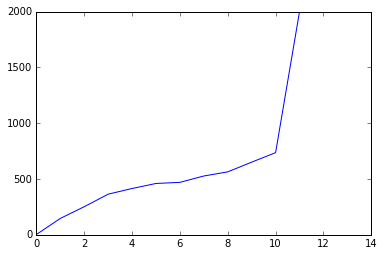

In [51]:
plot(runtime);show()

In [55]:
n=55
H = spikeH(n,0.2,0.5)
psi0   = state0(n)
greedyK_openT(H,dt,psi0,20,2000,0.001)

1999

[ 0.68279132  0.61939841  0.4897235   2.2947415 ] 0.33365253472 0.00882768866584
[ 2.45638928  0.06781564  1.09346446  3.13879353] 0.331939568226 0.00657531864256
[ 0.22602445  1.38060751  0.61669544  2.95361586] 0.326110488995 0.0374997413173
[ 2.85123663  0.16779148  0.93606253  1.76770292] 0.346071786205 0.0418683363599
[ 2.13280482  3.09750277  2.03815115  0.69692454] 0.319740155765 0.00081605489518
[ 0.67685954  1.80757132  0.46768052  1.0376012 ] 0.330607802824 0.00358600808855
[ 2.47020411  1.89648309  1.0948687   2.79171981] 0.331412074772 0.00377715648241
[ 0.63315719  2.57736488  0.53424567  1.10895548] 0.340394255719 0.00982611288257
[ 0.40245519  1.51755393  0.59591551  2.34237894] 0.350898327872 0.0256649967891
[ 2.61570771  2.91927266  2.01872647  1.19197331] 0.311428649819 0.000938471379435
[ 0.62840258  2.03372995  0.51684301  2.12503096] 0.33891775512 0.00585762182266
[ 0.61615512  0.49110735  0.53038887  2.58844781] 0.338705661744 0.0069917974258
[ 0.91454916  2.78219

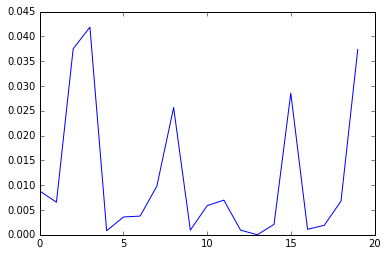

In [45]:
beta = []
gamma = []
emin = []
overlaps=[]
for n in range(35,55,1):
    psi0= state0(n)     
    #H = spikeH(n, 0.0,0.0)
    H = cubicH(n)
    bg, E, psiOpt = greedyQAOA(H,psi0,2)
    #beta.append(b)
    #gamma.append(g)
    emin.append(E)
    print bg%pi, E, np.abs(psiOpt[0])**2
    overlaps.append(np.abs(psiOpt[0])**2)
    
plot(overlaps); show()

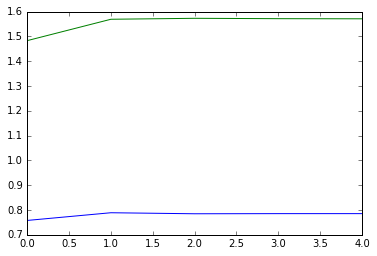

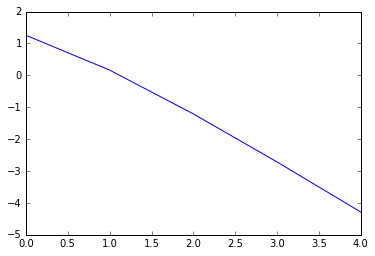

In [12]:
plot(beta);plot(gamma);show()
plot(map(np.log,emin));show()

In [38]:
energy(H[1],np.dot(expm(-1.j*H[0]*pi/4),np.dot(expm(-1.j*H[1]*pi/2.),psi0)))

(5.6489393255350224e-11+0j)

In [18]:
np.array(beta)*4

array([ 3.03164193,  3.15582113,  3.13934729,  3.14139295,  3.14153223])

In [36]:
psi0= state0(200)     
H = spikeH(200,0.0,0.0)
psi=psi0
angles=[]
E = [energy(H[1],psi0)]
def Etrial(x): 
    psi=psi0
    for i in range(1):
        psi = np.dot(expm(-1.j*H[0]*x[2*i]), np.dot(expm(-1.j*H[1]*x[2*i+1]),psi))
    return energy(H[1],psi)
Etrial([pi/4,pi/2])

(5.6489393255350224e-11+0j)

90

In [114]:
637.05475149%(pi)

2.4530354648617347